In [1]:
!pip3 install networkx

    100% |████████████████████████████████| 1.6MB 144kB/s ta 0:00:01


In [1]:
import networkx as nx
import pandas as pd
import numpy as np

## Epinions - first dataset

We must first clean the mess within Epinions trust dataset in order to import it in NetworkX

In [2]:
path_trust_epi = './trust_data.txt'
path_trust_epi_clean = './trust_data_clean.txt'

In [3]:
import os
def remove_space(path,path_clean):
    if os.path.exists(path_clean):
        os.remove(path_clean)
    with open(path_clean, 'w') as file_clean:
        with open(path, 'r') as file:
            for line in file:
                file_clean.write(line[1:-1]+'\n')

In [31]:
remove_space(path_trust_epi,path_trust_epi_clean)

In [64]:
G = nx.read_edgelist(path_trust_epi_clean, create_using=nx.DiGraph, nodetype=int, data=(("weight", int),))

### Size

In [25]:
trust_size = len(G.nodes)
trust_nb_edges = len(G.edges)

print("nodes (users):", trust_size, "|", "edges (trust relations):", trust_nb_edges)

nodes (users): 49288 | edges (trust relations): 487183


### Distribution

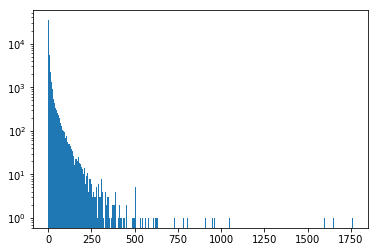

In [55]:
import matplotlib.pyplot as plt

def plot_degree_dist(G,degree_func,bin_size):
    degrees = [degree_func(n) for n in G.nodes()]
    plt.yscale('log')
    #plt.xscale('log')
    density = plt.hist(degrees, bins=[i for i in range(0,max(degrees)+bin_size,bin_size)])
    plt.show()
    return density
    
density = plot_degree_dist(G,G.out_degree,5)

In [9]:
print(max(density[0])/trust_size,np.argmax(density[0]))

0.7017935400097387 0


The size of the bins are currently 5, and the Y-scale is logarithmic.


The most populated interval for out degree distribution is [0, 4] (second is [5, 9], then [10, 14], etc).
It means that 70\% of the users trust less than 5 other users.

In [16]:
print("number of isolated nodes : ",len(list(nx.isolates(G))))

number of isolated nodes :  0


There is no isolated node in this dataset, so it means 70% users trust between 1 and 4 other users.

### Distribution law
We can see that our Epinions trust dataset follows a Pareto distribution (80-20 exponential distribution law)

### Density

In [52]:
nx.density(G)

0.00020054809698621774

Our social media has a very low density, which means that the user-user matrix will be very sparse.

## Delicious - second dataset

In [40]:
path_contact_del = './user_contacts-timestamps.dat'

In [41]:
data = np.genfromtxt(path_contact_del,
                     skip_header=1,
                     dtype=int,
                     names=True,
                     usecols=(0,1),
                     delimiter='\t')
print(data[0:10])

[( 8,  40306) ( 8,  85279) ( 8,  91764) ( 8,  97723) ( 8, 105468)
 ( 8, 106690) (32,   3203) (32,   7978) (32,   8670) (32,  12847)]


In [42]:
G_del = nx.from_edgelist(data)

Note that this time, the graph is undirected.

### Size

In [57]:
contact_size = len(list(G_del.edges))
user_size = len(list(G_del.nodes))
print("edges:",contact_size,"| nodes:", user_size)

edges: 7664 | nodes: 1861


In [61]:
print("number of isolated nodes : ",len(list(nx.isolates(G_del))))

number of isolated nodes :  0


### Distribution

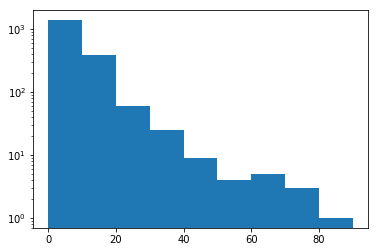

In [58]:
density_del = plot_degree_dist(G_del,G_del.degree,10)

In [59]:
print(max(density_del[0])/user_size,np.argmax(density_del[0]))

0.7345513164965073 0


We observe the same phenomenom : 73\% of users have between 1 and 9 contacts, even with an undirected graph.

### Distribution law
Same as the previous dataset for the relationships between users : Pareto distribution

### Density

In [62]:
nx.density(G_del)

0.0044281892611788085

This dataset is way les sparce than Epinions, which means that the Delicious user-user matrix will be sparse
but a lot less that what we estimated in Epinions.